# **Imports** 

In [5]:
%%capture
!pip install pycountry
! pip install -q "tqdm>=4.36.1"

# NLP modules
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
# NLTK downloads
nltk.download("punkt")
nltk.download('wordnet')
nltk.download("stopwords")
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [6]:
# Data handling and system modules 
import os
import sys
import pickle
import datetime
import string
import itertools
import regex as re
import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm
from pycountry import countries
from collections import Counter, defaultdict

# parallel processing
import multiprocessing as mp
from multiprocessing import Pool
print(f"\n========Number of processors: {mp.cpu_count()}========\n")

def parallelize_dataframe(df, func, n_cores=int(mp.cpu_count())):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# preprocessing modules
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Plotting modules
from matplotlib import rc
from matplotlib import style 
import matplotlib.pyplot as plt
style.use('seaborn-bright')
plt.rcParams['font.family'] = "serif"
import plotly
import seaborn as sns
import plotly.graph_objects as go

# NLP modules
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Colab notebook display configuring
from google.colab import drive
drive.mount('/content/gdrive')
import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

os.chdir('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/data/raw_data')
print(f'What files are in the current directory?\n-{os.listdir()}')
%matplotlib inline


========Number of processors: 2========

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
What files are in the current directory?
-['file_1.csv', 'file_2.csv', 'file_3.csv', 'file_4.csv', 'file_5.csv', 'file_6.csv']


#  **Raw data loading**

In [7]:
ds = pd.DataFrame()
headers = ['phone_url','date','lang', 'country','domain', 'score', 'extract','product']
for file in tqdm(os.listdir(), desc='Loading data....'):
  df = pd.read_csv(file,
                  encoding= "ISO-8859-1",
                  names=headers,
                  usecols=[0,1,2,3,5,6,8,10],
                  infer_datetime_format=True,
                  dayfirst = True)
  ds = pd.concat([ds, pd.DataFrame(df.values.tolist()[1:])], axis=0)
ds.columns = headers
ds['date'] = pd.to_datetime(ds['date'])
ds['product'] = ds['product'].apply(lambda x: str(x))
print(f'\n\nNumber of examples before \'not available\' removal: {ds.shape[0]}')
ds = ds.dropna(axis=0)
print(f'\n\nNumber of examples after \'not available\' removal: {ds.shape[0]}')
# splitting phone_url into manufacturer and model line information
ds['manufacturer'] =  [x.split('/')[2].split('-')[0].capitalize() for x in ds.phone_url.values.tolist()]
ds['model_line'] = [x.split('/')[2].split('-')[1].capitalize() for x in ds.phone_url.values.tolist()] 
ds

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.






Number of examples before 'not available' removal: 1415133


Number of examples after 'not available' removal: 1332699


,phone_url,date,lang,country,domain,score,extract,product,manufacturer,model_line
0,/cellphones/samsung-galaxy-s8/,2017-05-02,en,us,verizonwireless.com,10,As a diehard Samsung fan who has had every Sam...,Samsung Galaxy S8,Samsung,Galaxy
1,/cellphones/samsung-galaxy-s8/,2017-04-28,en,us,phonearena.com,10,Love the phone. the phone is sleek and smooth ...,Samsung Galaxy S8,Samsung,Galaxy
2,/cellphones/samsung-galaxy-s8/,2017-05-04,en,us,amazon.com,6,Adequate feel. Nice heft. Processor's still sl...,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl...",Samsung,Galaxy
3,/cellphones/samsung-galaxy-s8/,2017-05-02,en,us,samsung.com,9.2,Never disappointed. One of the reasons I've be...,Samsung Galaxy S8 64GB (AT&T),Samsung,Galaxy
4,/cellphones/samsung-galaxy-s8/,2017-05-11,en,us,verizonwireless.com,4,I've now found that i'm in a group of people t...,Samsung Galaxy S8,Samsung,Galaxy
...,...,...,...,...,...,...,...,...,...,...
163832,/cellphones/alcatel-ot-club_1187/,2000-05-12,de,de,ciao.de,2,Weil mein Onkel bei ALcatel arbeitet habe ich ...,Alcatel Club Plus Handy,Alcatel,Ot
163833,/cellphones/alcatel-ot-club_1187/,2000-05-11,de,de,ciao.de,10,Hy Liebe Leserinnen und Leser!! Ich habe seit ...,Alcatel Club Plus Handy,Alcatel,Ot
163834,/cellphones/alcatel-ot-club_1187/,2000-05-04,de,de,ciao.de,2,"Jetzt hat wohl Alcatell gedacht ,sie machen wa...",Alcatel Club Plus Handy,Alcatel,Ot
163835,/cellphones/alcatel-ot-club_1187/,2000-05-01,de,de,ciao.de,8,Ich bin seit 2 Jahren (stolzer) Besitzer eines...,Alcatel Club Plus Handy,Alcatel,Ot


# **Textual exploration: Mobile attributes distributions**

[('missing', 1291981), ('13mp', 26921), ('16mp', 5487), ('12mp', 2439), ('20mp', 2323), ('21mp', 1192), ('23mp', 625), ('10mp', 525), ('15mp', 491), ('41mp', 485), ('14mp', 47), ('50mp', 45), ('18mp', 39), ('450mp', 39), ('755mp', 28), ('720mp', 22), ('32mp', 7), ('30mp', 2), ('316mp', 1)]
[('missing', 1289699), ('black', 13560), ('gold', 6280), ('white', 5357), ('pink', 4513), ('silver', 3395), ('blue', 3351), ('grey', 2257), ('red', 2210), ('gray', 1075), ('green', 297), ('purple', 291), ('yellow', 240), ('golden', 174)]


[('missing', 1289699),
 ('black', 13560),
 ('gold', 6280),
 ('white', 5357),
 ('pink', 4513),
 ('silver', 3395),
 ('blue', 3351),
 ('grey', 2257),
 ('red', 2210),
 ('gray', 1075),
 ('green', 297),
 ('purple', 291),
 ('yellow', 240),
 ('golden', 174)]

[('missing', 1289699), ('black', 13560), ('gold', 6280), ('white', 5357), ('pink', 4513), ('silver', 3395), ('blue', 3351), ('grey', 2257), ('red', 2210), ('gray', 1075), ('green', 297), ('purple', 291), ('yellow', 240), ('golden', 174)]
Verizon|Cricket|Tim|Vodafone|Boost|T-Mobile|Tracfone|Sprint|AT&T
[('missing', 1224686), ('Verizon', 33784), ('AT&T', 23497), ('T-Mobile', 19694), ('Sprint', 13225), ('Vodafone', 5428), ('Boost', 4834), ('Tracfone', 3761), ('Tim', 2747), ('Cricket', 1043)]


[('missing', 1224686),
 ('Verizon', 33784),
 ('AT&T', 23497),
 ('T-Mobile', 19694),
 ('Sprint', 13225),
 ('Vodafone', 5428),
 ('Boost', 4834),
 ('Tracfone', 3761),
 ('Tim', 2747),
 ('Cricket', 1043)]

Verizon|Cricket|Tim|Vodafone|Boost|T-Mobile|Tracfone|Sprint|AT&T
[('missing', 1224686), ('Verizon', 33784), ('AT&T', 23497), ('T-Mobile', 19694), ('Sprint', 13225), ('Vodafone', 5428), ('Boost', 4834), ('Tracfone', 3761), ('Tim', 2747), ('Cricket', 1043)]


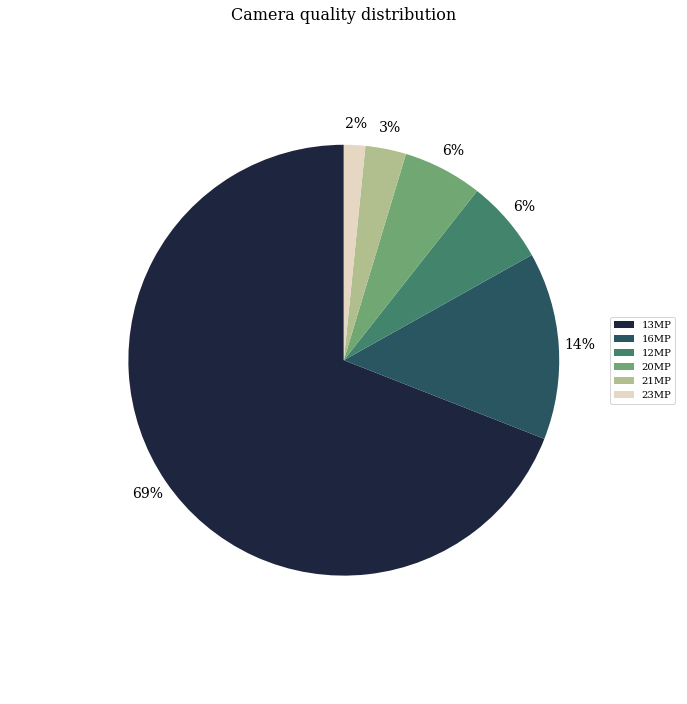

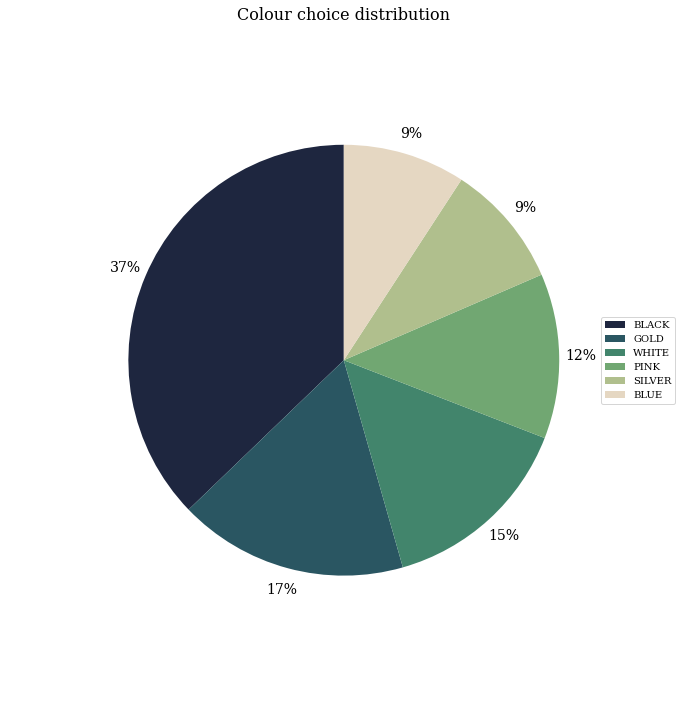

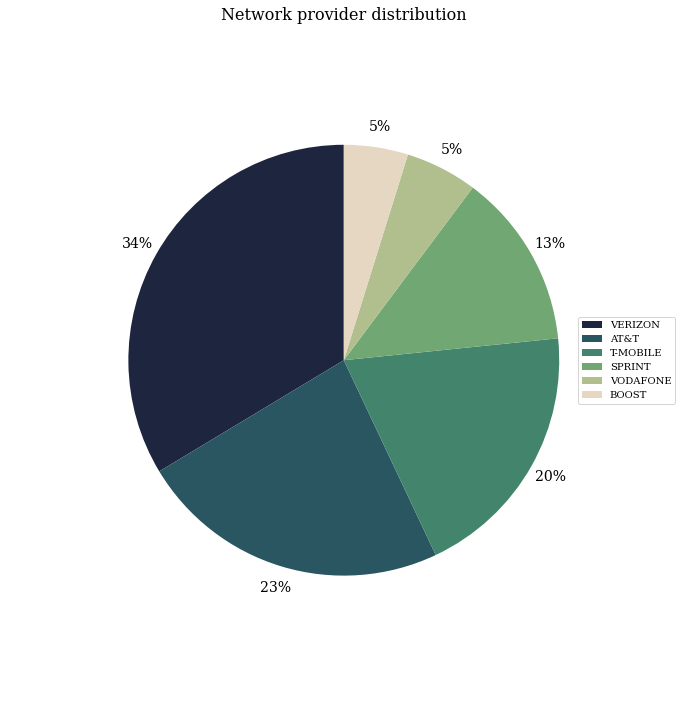

In [8]:
def pie_chart_plotting(name, size, title):
  fig1, ax1 = plt.subplots()
  fig1.set_figheight(10)
  fig1.set_figwidth(10)
  ax1.set_title(f'{title}', fontsize=16, pad=0.1)
  ax1.pie(s,autopct='%1.0f%%',textprops=dict(color="k", fontsize=14),
          shadow=False, startangle=90, colors=sns.cubehelix_palette(6, start=.2, rot=-.75, reverse=True),
          pctdistance=1.1 ,radius=0.8)
  ax1.legend(labels=n, loc=7,)
  fig1.tight_layout()
  fig1.subplots_adjust(top=0.95)

def storage_normalising(data_frame, attribute=''):
  specifications = data_frame['product'].tolist()
  storage_re = re.compile('(\d{2}|\d{3})\s*(?=(gb|GB))')
  storage_found = [ storage_re.search(spec).group(1) +'gb' if storage_re.search(spec) !=None  else 'missing' for spec in specifications]
  print(Counter(storage_found).most_common(20))
  stor = Counter(storage_found).most_common(20)[1:6]
  s = [x[1] for x in stor]
  n = [x[0].upper() for x in stor]
  sns.color_palette("Blues")
  fig1, ax1 = plt.subplots()
  fig1.set_figheight(10)
  fig1.set_figwidth(10)
  ax1.set_title('Network provider distribution', fontsize=16, pad=0.1)
  ax1.pie(s,autopct='%1.0f%%',textprops=dict(color="k", fontsize=14),
          shadow=False, startangle=90, colors=sns.cubehelix_palette(6, start=.2, rot=-.75, reverse=True),  pctdistance=1.1 ,radius=0.8)
  ax1.legend(labels=n, loc=7,)
  fig1.tight_layout()
  fig1.subplots_adjust(top=0.95)
  return Counter(storage_found).most_common(20)

def camera_normalising(data_frame):
  specifications = data_frame['product'].tolist()
  storage_re = re.compile('(\d{2}|\d{3})(\.[0])?\s*(?=(mp|MP))')
  storage_found = [ storage_re.search(spec).group(1) +'mp' if storage_re.search(spec) !=None  else 'missing' for spec in specifications]
  print(Counter(storage_found).most_common(20))
  return Counter(storage_found).most_common(20)

def colour_normalising(data_frame):
  ''' func investigating colour distribution'''
  cols =['grey','pink','gold', 'silver', 'purple', 'yellow', 'golden', 'gray', 'white',
        'red','black','blue','green']
  specifications = data_frame['product'].tolist()
  regex_cols = [r'\b' + col +r'\b' for col in cols]
  regex_cols = "|".join(regex_cols) 
  col_re = re.compile(regex_cols)
  col_found = [ col_re.search(spec).group(0) if col_re.search(spec) !=None  else 'missing' for spec in specifications]
  print(Counter(col_found).most_common(20))
  return Counter(col_found).most_common(20)

def network_normalising(data_frame):
  ''' func investigating network provider distribution'''
  networks = ['Verizon','Cricket', 'Tim', 'Vodafone', 'Boost', 'T-Mobile', 'Tracfone', 'Sprint', 'AT&T']
  specifications = data_frame['product'].tolist()
  regex_net = "|".join(networks)
  net_re = re.compile(regex_net)
  print(regex_net)
  net_found = [ net_re.search(spec).group(0) if net_re.search(spec) !=None  else 'missing' for spec in specifications]
  print(Counter(net_found).most_common(20))
  return Counter(net_found).most_common(20)  

cam = camera_normalising(ds)
cam = cam[1:7]
s = [x[1] for x in cam]
n = [x[0].upper() for x in cam]
pie_chart_plotting(n, s, 'Camera quality distribution')

colour_normalising(ds)
col = colour_normalising(ds)
col = col[1:7]
s = [x[1] for x in col]
n = [x[0].upper() for x in col]
pie_chart_plotting(n, s, 'Colour choice distribution')

network_normalising(ds)
net = network_normalising(ds)
net = net[1:7]
s = [x[1] for x in net]
n = [x[0].upper() for x in net]
pie_chart_plotting(n, s, 'Network provider distribution')

# **Pre-processing: Language abbreviations ID**

In [22]:
lang_abb_list = tuple(set(ds.lang))
print(f'============================= Language abbreviations of dataset: {lang_abb_list}')
full_language_list = ()
not_recognised_abbreviation = ()
ordered_abb_ID = ()
for lang in lang_abb_list:
  try:
    full_language_list = full_language_list + (countries.lookup(lang).name,)
    ordered_abb_ID = ordered_abb_ID + (lang,)
  except LookupError:
    not_recognised_abbreviation = not_recognised_abbreviation + (lang,)
    pass
lang_abb = ordered_abb_ID + not_recognised_abbreviation
not_recongised_languages = ('Hebrew', 'Czech Repulic','Japan', 'China','England','Denmark')
all_lang = (*full_language_list, *not_recongised_languages)
# assert len(all_lang) == len(lang_abb)
country_abb_2name_dict = dict(zip(lang_abb, all_lang))
country_abb_2name_dict['sg'] = 'Singapore'
country_abb_2name_dict['in'] = 'India'
country_abb_2name_dict['au'] = 'Australia'
country_abb_2name_dict['us'] = 'United States'
country_abb_2name_dict['gb'] = 'Great Britain'
country_abb_2name_dict['ca'] = 'Canada'
country_abb_2name_dict['nz'] = 'New Zealand'
country_abb_2name_dict['za'] = 'South Africa'
print(country_abb_2name_dict)
os.chdir('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/data')
with open('language_abbreviation_dictionary.pickle', 'wb') as file_handle:
  pickle.dump(country_abb_2name_dict, file_handle)

============================= Language abbreviations of dataset: ('es', 'ar', 'cs', 'sv', 'fr', 'ru', 'pt', 'no', 'de', 'pl', 'ja', 'it', 'zh', 'fi', 'id', 'tr', 'en', 'nl', 'hu', 'da', 'he')
{'es': 'Spain', 'ar': 'Argentina', 'sv': 'El Salvador', 'fr': 'France', 'ru': 'Russian Federation', 'pt': 'Portugal', 'no': 'Norway', 'de': 'Germany', 'pl': 'Poland', 'it': 'Italy', 'fi': 'Finland', 'id': 'Indonesia', 'tr': 'Turkey', 'nl': 'Netherlands', 'hu': 'Hungary', 'cs': 'Hebrew', 'ja': 'Czech Repulic', 'zh': 'Japan', 'en': 'China', 'da': 'England', 'he': 'Denmark', 'sg': 'Singapore', 'in': 'India', 'au': 'Australia', 'us': 'United States', 'gb': 'Great Britain', 'ca': 'Canada', 'nz': 'New Zealand', 'za': 'South Africa'}


#**Exploratory plots: Origin country & language**

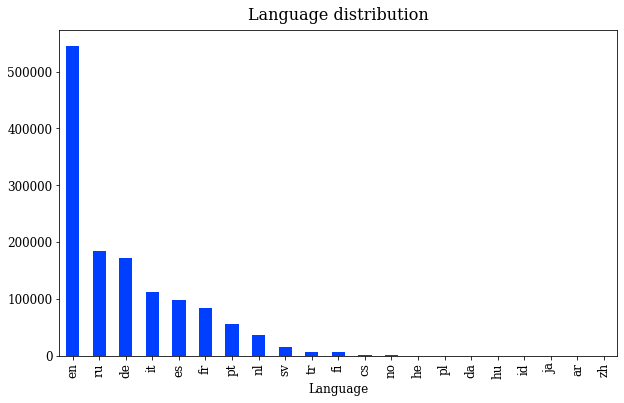

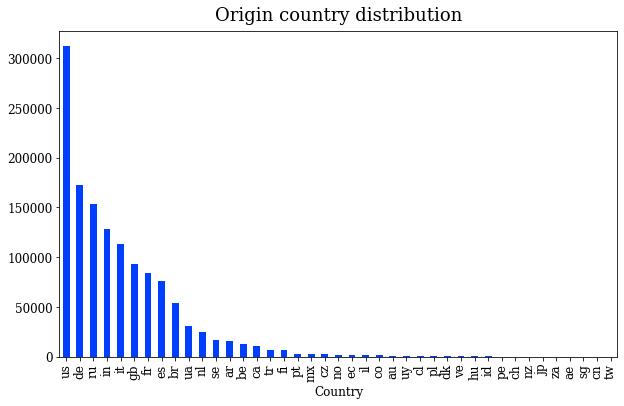

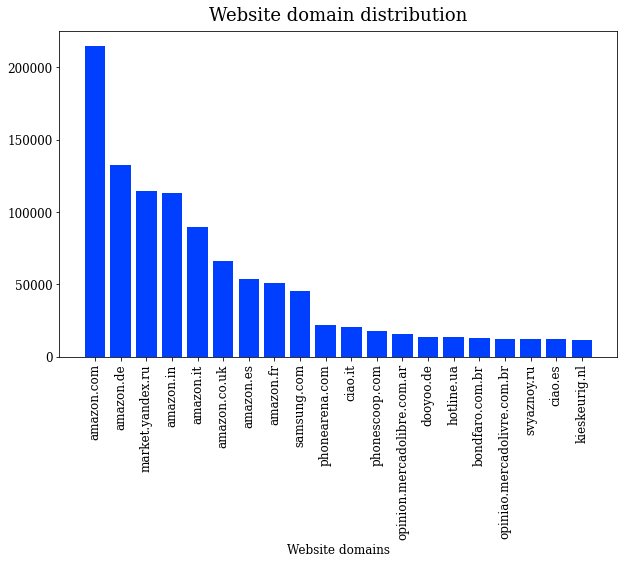

In [ ]:
def domain_count_plotting(data_frame_column ,number_of_classes, title, x_label, y_label):
  '''Historgram of origin website domain'''
  domain = Counter(data_frame_column.domain.to_list())
  bars = number_of_classes
  freq_counts  = domain.most_common(bars)
  x_points = np.arange(1, bars+1, 1)
  heights = [counts[1] for counts in freq_counts]
  names = [counts[0] for counts in freq_counts]
  plt.figure(figsize=(10,6))
  ax = plt.subplot(111)
  ax.bar(x_points, heights, width=0.8, bottom=None, align='center')
  ax.set_xlabel(f'{x_label}', fontsize='12')
  ax.set_title(f'{title}' , pad=10, fontsize=18)
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.tick_params(axis='x', labelrotation=90)
  ax.set_xticklabels(names)
  ax.set_xticks(x_points)

def language_distribution_plotting():
  '''histogram of language distribution'''
  plt.figure(figsize=(10,6))
  ds.lang = ds['lang'].astype("category")
  ax = ds['lang'].value_counts().plot(kind='bar')
  ax.set_xlabel('Language', fontsize='12')
  countries = ax.get_xticklabels()
  countries = list(countries)
  ax.set_title('Language distribution', pad=10, fontsize=16)
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

def origin_country_plotting():
  '''origin country histogram'''
  plt.figure(figsize=(10,6))
  ds.country = ds['country'].astype("category")
  ax = ds['country'].value_counts().plot(kind='bar')
  # countries_full_name = country_abb_2name_dict
  ax.set_xlabel('Country', fontsize='12')
  ax.set_title('Origin country distribution' , pad=10, fontsize=18)
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

language_distribution_plotting()
origin_country_plotting()
domain_count_plotting(ds, 20, 'Website domain distribution', 'Website domains', 'Counts')

#**Exploratory plot: Manufacturer insight**


{'Samsung': 343644, 'Nokia': 173457, 'Sony': 111096, 'Lg': 109184, 'Motorola': 84585, 'Apple': 81407, 'Htc': 65332, 'Huawei': 64369, 'Lenovo': 40948, 'Blackberry': 29281, 'Asus': 24382, 'Oneplus': 18505, 'Microsoft': 18402, 'Blu': 17163, 'Alcatel': 14962, 'Doogee': 10583, 'Cubot': 9907, 'Google': 9499, 'Xiaomi': 8742, 'Zte': 7853}


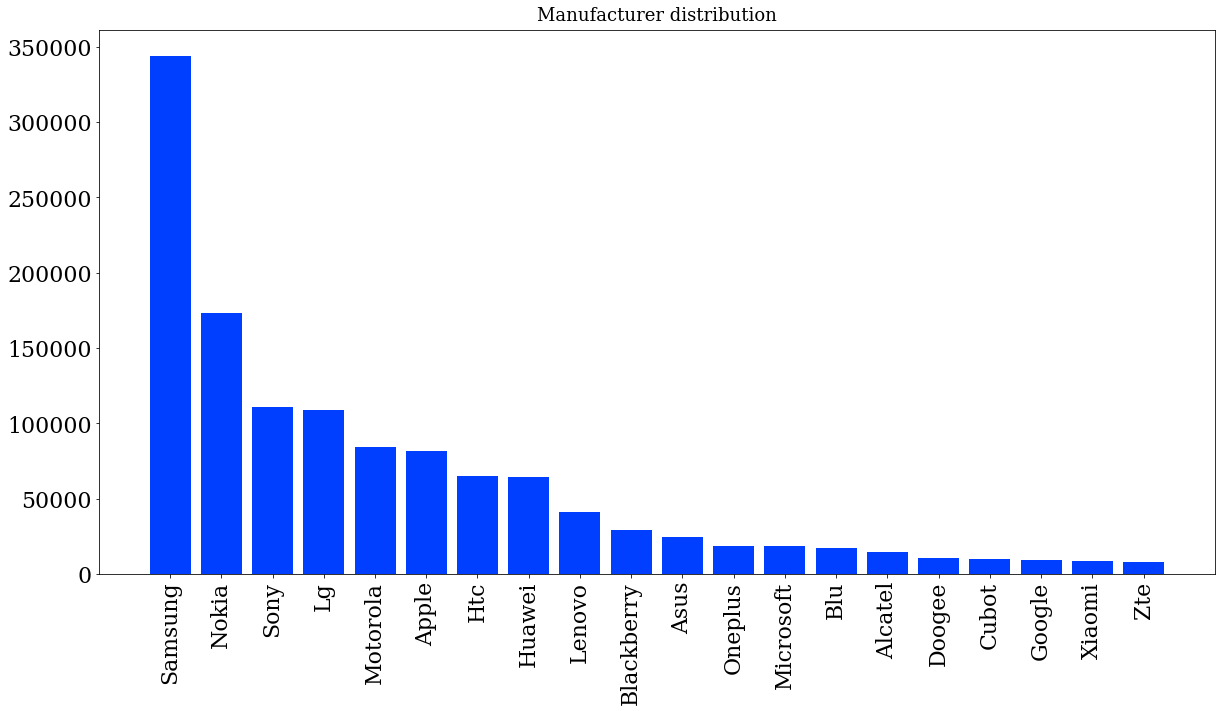

In [ ]:
def manufacturer_distribution_plotting(ds):
  '''Extracting manufacturer from url column and plotting distribution'''
  counter_manufacturers = dict(Counter(list(ds['manufacturer'].values.tolist())).most_common(20))
  print(counter_manufacturers)
  fig = plt.figure(figsize=(20,10))
  plt.bar(height=list(counter_manufacturers.values()), x=list(counter_manufacturers.keys()))
  plt.xticks(fontsize=22, rotation='vertical')
  plt.yticks(fontsize=22)
  plt.title('Manufacturer distribution',fontsize=18, pad=10)
  return counter_manufacturers

man_count_top10 = manufacturer_distribution_plotting(ds)

# **Exploratory plot: Manufacturer-score wise insight**

<Figure size 864x504 with 0 Axes>

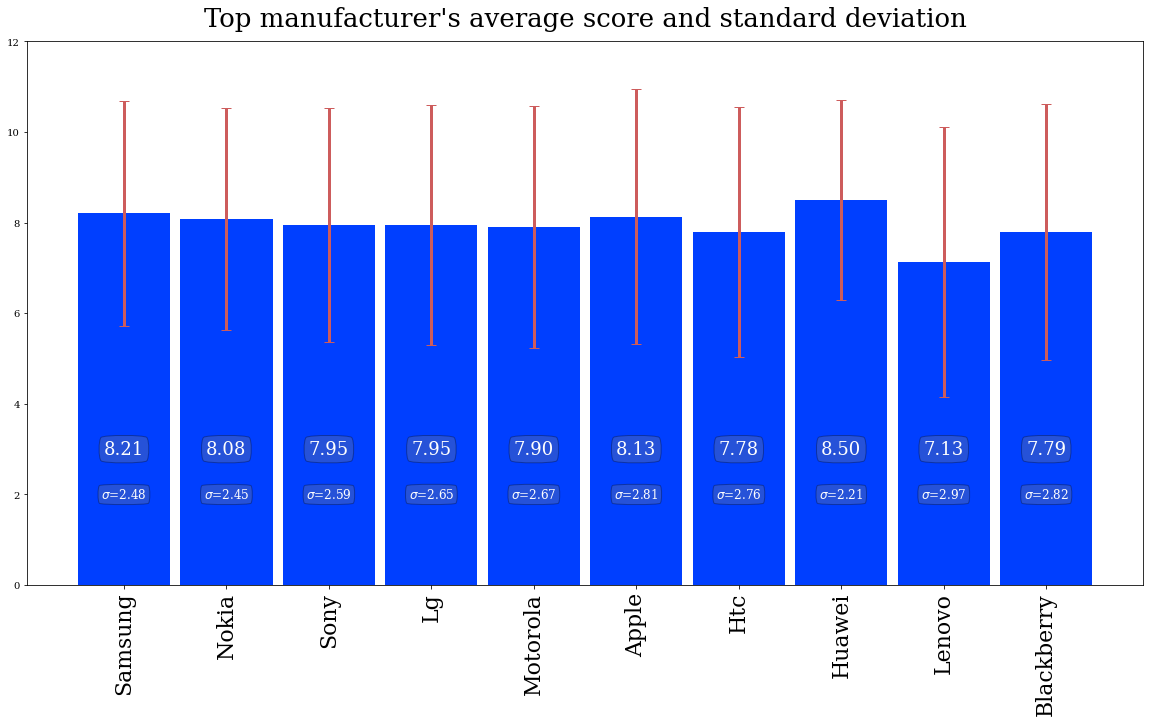

In [ ]:
def manufacturer_score_var_mean():
  fig = plt.figure(figsize=(12,7))
  ds['score'] = [ float(x) for x in ds.score ]
  avg_scores = ds.groupby(['manufacturer']).score.mean()
  avg_var = ds.groupby(['manufacturer']).score.var()

  top = tuple([x[0] for x in Counter(man_count_top10).most_common(10)]) 
  top_man_scores_var = []
  for top_man_var in top:
    top_man_scores_var.append(avg_var[top_man_var])
  top_man_scores = []
  for top_man in top:
    top_man_scores.append(avg_scores[top_man])
  fig, ax = plt.subplots()
  fig.set_figheight(10)
  fig.set_figwidth(20) 
  plt.title('Top manufacturer\'s average score and standard deviation',fontsize=26, pad=15)
  plt.bar(np.arange(0,len(top),1),top_man_scores, align='center', width=0.9)
  plt.ylim([0,12])
  ax.set_xticks(np.arange(0,16,1))
  ax.set_xticklabels(labels=top)
  plt.xticks(fontsize=22, rotation='vertical')
  for x in np.arange(0,len(top),1):
    ax.text(x,3, r'{0:.2f}'.format(top_man_scores[x]), color='white', fontsize=18,
            va='center', ha='center', bbox = dict(boxstyle='round4', facecolor='grey', alpha=0.3))
    ax.text(x,2, r'$\sigma$='+r'{0:.2f}'.format(np.sqrt(top_man_scores_var[x])),
            color='white', fontsize=12, va='center', ha='center', bbox = dict(boxstyle='round4', facecolor='grey', alpha=0.3)  )
    ax.errorbar(x=x ,y= top_man_scores[x] , yerr=np.sqrt(top_man_scores_var[x]), capsize=5, lw=3, color='indianred')

manufacturer_score_var_mean()

Text(0.5, 1.0, 'Score distribution of top 10 manufacturers')

[ 5 10 15 20 25 30 35 40 45 50]


<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10')]

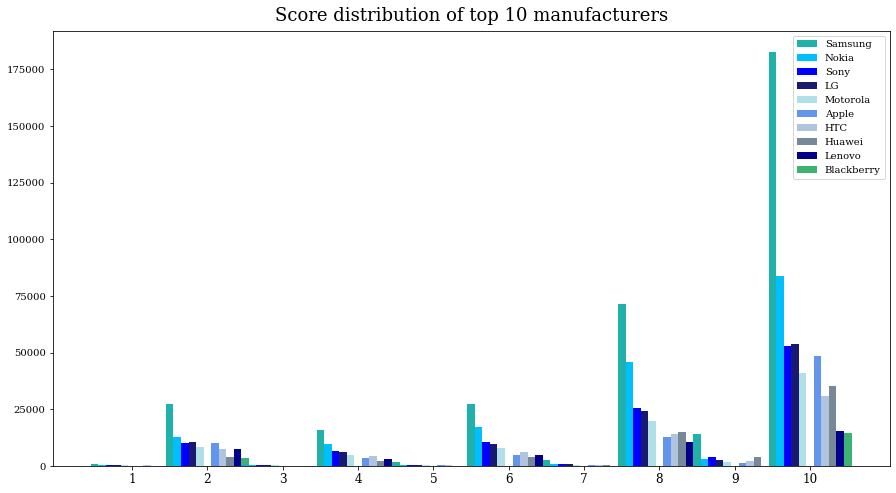

In [ ]:
def rebinning(score, counts):
  bins=np.arange(0.5, 10.5, 1)
  counts_collection = [0,0,0,0,0,0,0,0,0,0]
  for s, b in zip(score, counts):
    if 0.<s<=1.:
      counts_collection[0]+=b
    elif 1.<s<=2.:
      counts_collection[1]+=b
    elif 2.<s<=3.:
      counts_collection[2]+=b
    elif 3.<s<=4.:
      counts_collection[3]+=b
    elif 4.<s<=5.:
      counts_collection[4]+=b
    elif 5.<s<=6.:
      counts_collection[5]+=b      
    elif 6.<s<=7.:
      counts_collection[6]+=b
    elif 7.<s<=8.:
      counts_collection[7]+=b
    elif 8.<s<=9.:
      counts_collection[8]+=b
    elif 9<s<=10.:
      counts_collection[9]+=b
  
  return bins, counts_collection

df_man_model_score = ds[['manufacturer', 'model_line', 'score']]
df_man_model_score[['manufacturer', 'model_line']] = ds[['manufacturer', 'model_line']].astype('category')


def manufacturer_score_distribution(manufacturer_key,
                                    df):
  df_man_score_specified = df[df['manufacturer'] == manufacturer_key]
  d = df_man_score_specified.score.value_counts()
  x, y = rebinning(score = list(d.index),
                  counts = d.values)
  manufacturer_name = string.capwords(manufacturer_key)#  + ' score'
  return (manufacturer_name , y)

hist_counts = []
manufacturers_counts = []

man_name_list_ordered = tuple([x[0] for x in Counter(man_count_top10).most_common(10)])

for manufacturer in man_name_list_ordered:
  hist_counts.append(manufacturer_score_distribution(manufacturer_key=manufacturer,
                                  df = df_man_model_score)[1] )
  manufacturers_counts.append(manufacturer_score_distribution(manufacturer_key=manufacturer,
                                  df = df_man_model_score)[0]) 

ones = [x[0] for x in hist_counts]
twos= [x[1] for x in hist_counts]
threes=[x[2] for x in hist_counts]
fours=[x[3] for x in hist_counts]
fives =[x[4] for x in hist_counts]
sixes=[x[5] for x in hist_counts]
sevens= [x[6] for x in hist_counts]
eights =[x[7] for x in hist_counts]
nines =[x[8] for x in hist_counts]
tens =[x[9] for x in hist_counts]
counts = [ones, twos, threes, fours, fives, sixes, sevens, eights, nines, tens]

fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.set_title('Score distribution of top 10 manufacturers',fontsize=18, pad=10)
x = np.arange(5, 55, 5)
print(x)

for i in range(0,9):
  w = 0.5
  ax.bar(x[i]-5*w, counts[i][0], width=w, color='lightseagreen', align='center')
  ax.bar(x[i]-4*w, counts[i][1], width=w, color='deepskyblue', align='center')
  ax.bar(x[i]-3*w, counts[i][2], width=w, color='blue', align='center')
  ax.bar(x[i]-2*w, counts[i][3], width=w, color='midnightblue', align='center')
  ax.bar(x[i]-w, counts[i][4], width=w, color='powderblue', align='center')

  ax.bar(x[i]+w, counts[i][5], width=w, color='cornflowerblue', align='center')
  ax.bar(x[i]+2*w, counts[i][6], width=w, color='lightsteelblue', align='center')
  ax.bar(x[i]+3*w, counts[i][7], width=w, color='lightslategray', align='center')
  ax.bar(x[i]+4*w, counts[i][8], width=w, color='darkblue', align='center')
  ax.bar(x[i]+5*w, counts[i][9], width=w, color='mediumseagreen', align='center')

i=9
ax.bar(x[i]-5*w, counts[i][0], width=w, color='lightseagreen', align='center', label=f'{man_name_list_ordered[0]}')
ax.bar(x[i]-4*w, counts[i][1], width=w, color='deepskyblue', align='center', label=f'{man_name_list_ordered[1]}')
ax.bar(x[i]-3*w, counts[i][2], width=w, color='blue', align='center', label=f'{man_name_list_ordered[2]}')
ax.bar(x[i]-2*w, counts[i][3], width=w, color='midnightblue', align='center', label=f'{man_name_list_ordered[3].upper()}')
ax.bar(x[i]-w, counts[i][4], width=w, color='powderblue', align='center', label=f'{man_name_list_ordered[4]}')

ax.bar(x[i]+w, counts[i][5], width=w, color='cornflowerblue', align='center', label=f'{man_name_list_ordered[5] }')
ax.bar(x[i]+2*w, counts[i][6], width=w, color='lightsteelblue', align='center', label=f'{man_name_list_ordered[6].upper()}')
ax.bar(x[i]+3*w, counts[i][7], width=w, color='lightslategray', align='center', label=f'{man_name_list_ordered[7]}')
ax.bar(x[i]+4*w, counts[i][8], width=w, color='darkblue', align='center', label=f'{man_name_list_ordered[8]}')
ax.bar(x[i]+5*w, counts[i][9], width=w, color='mediumseagreen', align='center', label=f'{man_name_list_ordered[9]}')

ax.set_xticks(ticks = x)
ax.set_xticklabels(labels=[1,2,3,4,5,6,7,8,9,10], fontsize=12)
ax.legend()


# **Preprocess: Polarity assignment**
{-1:Negative, 0:Neutral, 1:Positive}

For lower bound cut-off of 4.0, porition of negative reviews: 15.38%

For upper bound cut-off of 9.0, porition of neutral reviews: 34.53%

For lower and upper bound cut-off of 4.0 and 9.0, porition of positive reviews: 50.09%



Text(0.5, 1.0, 'Assigned sentiment distribution of top 10 manufacturers')

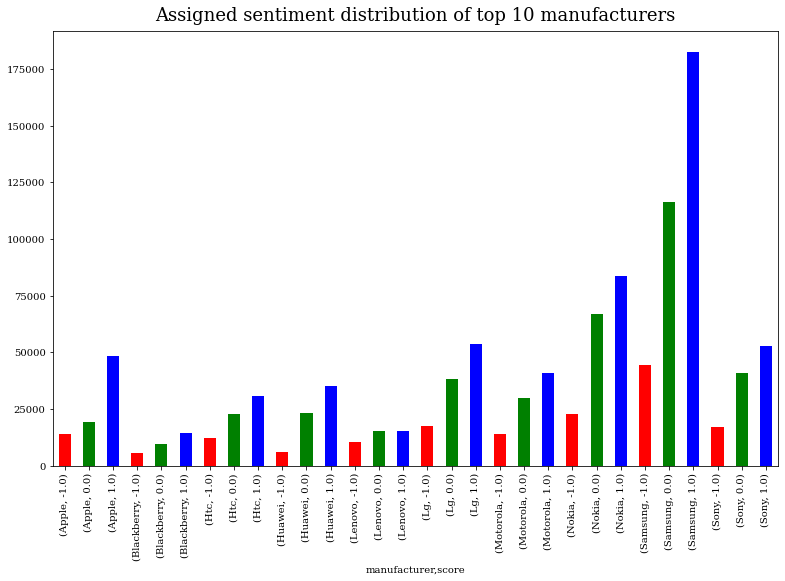

In [ ]:
LB_C, UB_C = 4.0, 9.0 ##########################################################
ds_neg = ds[ds.score <= LB_C]
print(f'For lower bound cut-off of {LB_C}, porition of negative reviews: {ds_neg.shape[0]*100/ds.shape[0]:.2f}%\n')
ds_neut = ds[(LB_C < ds.score) & (ds.score <= UB_C)]
print(f'For upper bound cut-off of {UB_C}, porition of neutral reviews: {ds_neut.shape[0]*100/ds.shape[0]:.2f}%\n')
ds_pos = ds[ds.score > UB_C]
print(f'For lower and upper bound cut-off of {LB_C} and {UB_C}, porition of positive reviews: {ds_pos.shape[0]*100/ds.shape[0]:.2f}%\n')

ds['score'][ds.score <= LB_C] = int(-1)
ds['score'][(ds.score > LB_C) & (ds.score  <= UB_C)] = int(0)
ds['score'][ds.score > UB_C] = int(1)

fig = plt.figure(figsize=(13,8))
ax = plt.subplot(111)
ax.set_title('Assigned sentiment distribution of top 10 manufacturers',
             fontsize=18,
             pad=10)
ds_top_man = ds[ ds['manufacturer'].isin(man_name_list_ordered)]
man_wise_sentiment = ds_top_man.groupby(['manufacturer','score'])['score'].count()
man_wise_sentiment.plot(kind='bar',
                        color=['r', 'g', 'b'], ax=ax)

#**Exploratory plot: Categorical data insight:**
###Language, country,	domain, manufacturer &	model line


In [ ]:
def pairplot_cat_variables():
  '''Encoding data using vanilla label encoding: Ordinal encoding BUT  nominal variables'''
  scat_df = ds[['country', 'domain', 'manufacturer', 'model_line', 'score']]
  encoder_dict = defaultdict(LabelEncoder)
  forward_transform_lambda = lambda x: encoder_dict[x.name].fit_transform(x)
  inverse_transform_lambda = lambda x: encoder_dict[x.name].inverse_transform(x)
  df = pd.concat( [scat_df[['country', 'domain', 'manufacturer', 'model_line']].apply(forward_transform_lambda),
                  scat_df[['score']]], axis=1)  
  g = sns.pairplot(df)
  g.fig.set_size_inches(20,20)
  g.fig.suptitle("Nominal features pairwise plot", size=18, y=1.05)


def categorically_data_correlation(df, cats=True):
  ''' Function causes RAM issues'''
  cat_corr_df = df[['country','domain','manufacturer','model_line']]
  encoding_dict, ticks, concat_1hot_encoded = {}, [], [] 
  # One hot encoding
  for name in cat_corr_df:
    concat_1hot_encoded.append(pd.get_dummies(cat_corr_df[f'{name}'], prefix=f'{name}', drop_first=True))
  Xt_corr = pd.concat([*encoding_dict,df.score], axis=1)
  # Convert to categorical type and assign encoding column header names 
  for col in Xt_corr.columns[:-1]: 
    Xt_corr[col]= Xt_corr[col].astype('category')
  for col in Xt_corr.columns[:-1]:
    Xt_corr[col+'_enc']= Xt_corr[[col]].squeeze().cat.codes
  # print old vs new headers
  for (new_col, old_col) in list(zip(Xt_corr.columns[279:],Xt_corr.columns[:279])):
    print(f'The old headers: {old_col}\n'\
          f'=== new =======: {new_col}')
    ticks.append(old_col)
    encoding_dict[new_col] = dict( zip( Xt_corr[old_col].cat.codes, Xt_corr[old_col]))

  encoded_column_headers= Xt_corr.columns[278:].tolist()
  print(f'The headers to keep are: {encoded_column_headers}')
  Xt_corr = Xt_corr[encoded_column_headers]
  Xt_corr.head(5)
  for key in list(encoding_dict.keys()):
    print(f'Encoding for corresponding key {list(encoding_dict[key].items())[:10]}')
    print(f'Encoding key for dictionary: {key}\n\n')
  rename_dict = {'country_enc':'Country',
                'domain_enc':'Domain',
                'manufacturer_enc':'Manufacturer',
                'model_line_enc':'Model line',
                'score':'Sentiment'}
  Xt_corr = Xt_corr.rename(columns=rename_dict)
  ticks = Xt_corr.columns.tolist()
  if cats == True:
    f = plt.figure(figsize=(8, 10))
    plt.matshow(Xt_corr.corr(), fignum=f.number, cmap='Blues')
                        #1                    #1                           #1                    #1
    plt.xticks(np.arange(70,Xt_corr.shape[1],70), Xt_corr.columns[np.arange(70,Xt_corr.shape[1],70)], fontsize=14, rotation=45)
    plt.yticks(np.arange(70,Xt_corr.shape[1],70), Xt_corr.columns[np.arange(70,Xt_corr.shape[1],70)], fontsize=14)
    cb = plt.colorbar(shrink=0.64)
    cb.ax.tick_params(labelsize=14)
    plt.title('Auxiliary variable correlation matrix', fontsize=18, pad=80)

# categorically_data_correlation(ds)
# pairplot_cat_variables()

# **Preprocess: Textual information**
Data reduction: Reviews authored in English only

In [ ]:
print(f'Dataset size prior to reduction: {ds.shape[0]}')
df = ds[ds['lang'] == 'en']
print(f'Dataset size posterior to reduction: {df.shape[0]}\n\n Example reviews:')

def lower_casing(tokens):
  ''' In place tokenization'''
  return [token.lower() for token in tokens]

def punctuation_normalising(tokens):
  ''' Punctuation removal. CAREFUL: " means inch and so on.  '''
  tokens = [ re.sub('\.' ,'', token) for token in tokens]
  tokens = [ re.sub('\,' ,'', token) for token in tokens]
  tokens = [ re.sub('\+' ,'', token) for token in tokens]
  tokens = [ re.sub('\(', '', token) for token in tokens]
  tokens = [ re.sub('\)', '', token) for token in tokens]
  tokens = [ re.sub('\!', '', token) for token in tokens]
  tokens = [ re.sub('\#', '', token) for token in tokens]
  tokens = [ re.sub('\$', '', token) for token in tokens]
  tokens = [ re.sub('\&', '', token) for token in tokens]
  tokens = [ re.sub('\?', '', token) for token in tokens]
  tokens = [ re.sub('\;', '', token) for token in tokens]
  tokens = [ re.sub('\=', '', token) for token in tokens]
  tokens = [ re.sub('\@', '', token) for token in tokens]
  tokens = [ re.sub('\/', '', token) for token in tokens]
  tokens = [ re.sub('\:', '', token) for token in tokens]
  tokens = [ re.sub('\-', '', token) for token in tokens]
  return tokens 

def lemmatization(tokens):
  '''Function takes in tokens performs parts of speech  (POS) tagging 
  and uses the found tags to correctly lemmatise the tokens. Assuming verbs'''
  try: 
    pos_tags=[ tag[1] for tag in pos_tag(tokens)]
    pos_tags = [tag[0].lower() for tag in pos_tags]
    pos_tag_set = tuple(set(pos_tags)) + ('n', 'i','d' ,'c', 'j','r', 'm', '.', 'w',':','--',"''", ',','(',')','p','t','u','f','``',"'",'l','v','e', '$','s','#' )
    pos_tag_set_replacement = ('v' for i in range(len(pos_tag_set)))
    pos_dict_replacement = {key:value for key, value in zip(pos_tag_set, pos_tag_set_replacement)}
    pos_tags_adjusted = [pos_dict_replacement[pos_tag_individual] for pos_tag_individual in pos_tags ]
    tokens = [lemmatizer.lemmatize(token, pos=f'{pos}') for token, pos in zip(tokens, pos_tags_adjusted)]
  except IndexError: 
    pass
  return tokens

tqdm.pandas() # required to show progression bar for pandas dataframe
print('\nSplitting....\n')
df['token'] = df['extract'].progress_apply(lambda x: x.split(' ') )
df['token'][100:110]

print('\nlower casing....\n')
df['token'] = df['token'].progress_apply(lower_casing)
df['token'][100:110]

print('\npunctation removal....\n')
df['token'] = df['token'].progress_apply(punctuation_normalising)
df['token'][100:110]

print('\nlemmatization....\n')
df['token'] = df['token'].progress_apply(lemmatization)
df['token'][100:110]


df['extract'] = df['token'].apply(lambda x: ' '.join(x))
df.drop(columns=['token'], inplace=True)
os.chdir('/content/gdrive/My Drive/Colab Notebooks/phone_user_reviews/nlp_scripts/data')

with open('df_ENGLISH_ONLY.pickle', 'wb') as file_handle:
  pickle.dump(df, file_handle)

Dataset size prior to reduction: 1332699
Dataset size posterior to reduction: 545424

 Example reviews:

Splitting....



100    [The, Galaxy, S8, is, very, fast, and, a, very...
101    [Love, my, new, GS8., Great, phone, with, nice...
102    [GREAT, PHONE, n, I, will, recommended, to, I,...
103    [The, phone, is, very, light, comparing, to, t...
104    [The, phone, looks, great,, works, good..but, ...
105    [Clunky, is, the, best, word, for, it., The, n...
106    [Pre, ordered, and, received, early., Amazing,...
107    [I, was, amazed, by, the, Samsung, Galaxy, S8+...
108    [I, was, iPhone, user, for, ten, years, and, I...
109    [Awesome, phone, HATE, I, BIXBY, and, there, s...
Name: token, dtype: object


lower casing....



100    [the, galaxy, s8, is, very, fast, and, a, very...
101    [love, my, new, gs8., great, phone, with, nice...
102    [great, phone, n, i, will, recommended, to, i,...
103    [the, phone, is, very, light, comparing, to, t...
104    [the, phone, looks, great,, works, good..but, ...
105    [clunky, is, the, best, word, for, it., the, n...
106    [pre, ordered, and, received, early., amazing,...
107    [i, was, amazed, by, the, samsung, galaxy, s8+...
108    [i, was, iphone, user, for, ten, years, and, i...
109    [awesome, phone, hate, i, bixby, and, there, s...
Name: token, dtype: object


punctation removal....



100    [the, galaxy, s8, is, very, fast, and, a, very...
101    [love, my, new, gs8, great, phone, with, nice,...
102    [great, phone, n, i, will, recommended, to, i,...
103    [the, phone, is, very, light, comparing, to, t...
104    [the, phone, looks, great, works, goodbut, it,...
105    [clunky, is, the, best, word, for, it, the, ne...
106    [pre, ordered, and, received, early, amazing, ...
107    [i, was, amazed, by, the, samsung, galaxy, s8,...
108    [i, was, iphone, user, for, ten, years, and, i...
109    [awesome, phone, hate, i, bixby, and, there, s...
Name: token, dtype: object


lemmatization....



100    [the, galaxy, s8, be, very, fast, and, a, very...
101    [love, my, new, gs8, great, phone, with, nice,...
102    [great, phone, n, i, will, recommend, to, i, k...
103    [the, phone, be, very, light, compare, to, the...
104    [the, phone, look, great, work, goodbut, it, d...
105    [clunky, be, the, best, word, for, it, the, ne...
106    [pre, order, and, receive, early, amaze, phone...
107    [i, be, amaze, by, the, samsung, galaxy, s8, i...
108    [i, was, iphone, user, for, ten, years, and, i...
109    [awesome, phone, hate, i, bixby, and, there, s...
Name: token, dtype: object

In [ ]:
def corpus_terminology_normalisation(tokens):
  '''Normalising appearance of mobile phone attributes in text. For Variational
    autoencoder'''
  tokens = [ re.sub('(?<=\d{2})\s' ,'', token) for token in tokens]                   # find two digits in row -> contract following white space
  tokens = [ re.sub('(?<=\d\.\d)\s', '', token) for token in tokens]                  # find digit.digit (like 12.0) contract following white space
  tokens = [ re.sub('"', 'inch', token) for token in tokens]                          # replace symbol for 'inch' with inch
  tokens = [ re.sub('\s*(inches)', 'inch', token) for token in tokens]                # replace inches with a possible white space with inch 
  tokens = [ re.sub('megapixel', 'mp', token) for token in tokens]                    # replace megapixel with mp
  tokens = [ re.sub('megapixels', 'mp', token) for token in tokens ]                  # replace megapixels with mp
  tokens = [ re.sub('mpixels', 'mp', token) for token in tokens]                      # replace mpixels with mp
  tokens = [ re.sub('\s(?=(gb))', '', token) for token in tokens]                     # contract whitespace in front of gb
  tokens = [ re.sub('\s(?=(mp))', '',token) for token in tokens]                      # contract whitespace in front of mp
  return tokens